In [0]:
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow.data as data

import keras
import keras.datasets as datasets
import keras.models as models
import keras.layers as layers

import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import imageio
import PIL
import time

from IPython import display

In [180]:
!pwd

!mkdir /content/projects/;
!mkdir /content/projects/generative;
!mkdir /content/projects/generative/mnist;

import os
os.chdir('/content/projects/generative/mnist')

!pwd

/content/projects/generative/mnist
mkdir: cannot create directory ‘/content/projects/’: File exists
mkdir: cannot create directory ‘/content/projects/generative’: File exists
mkdir: cannot create directory ‘/content/projects/generative/mnist’: File exists
/content/projects/generative/mnist


In [181]:
!pip install imageio

In [0]:
# Load the dataset
(train_images, train_labels), (_, _) = datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
train_dataset = data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
# Create the models

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(
        tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,))
    )
    model.add(
        tf.keras.layers.BatchNormalization()
    )
    model.add(
        tf.keras.layers.LeakyReLU()
    )
    
    model.add(
        tf.keras.layers.Reshape((7,7,256))
    )
    assert model.output_shape == (None, 7, 7, 256)
    
    model.add(
        tf.keras.layers.Conv2DTranspose(
            128, 
            (5, 5), 
            strides=(1, 1), 
            padding='same', 
            use_bias=False
        )
    )
    assert model.output_shape == (None, 7, 7, 128)
    model.add(
        tf.keras.layers.BatchNormalization()
    )
    model.add(
        tf.keras.layers.LeakyReLU()
    )
    
    model.add(
        tf.keras.layers.Conv2DTranspose(
            64, 
            (5, 5), 
            strides=(2, 2), 
            padding='same', 
            use_bias=False
        )
    )
    assert model.output_shape == (None, 14, 14, 64)
    model.add(
        tf.keras.layers.BatchNormalization()
    )
    model.add(
        tf.keras.layers.LeakyReLU()
    )
    
    model.add(
        tf.keras.layers.Conv2DTranspose(
            1, 
            (5, 5), 
            strides=(2, 2), 
            padding='same', 
            use_bias=False,
            activation='tanh'
        )
    )
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(
        tf.keras.layers.Conv2D(
            64,
            (5,5),
            strides=(2,2),
            padding='same'
        )
    )
    model.add(
        tf.keras.layers.LeakyReLU()
    )
    model.add(
        tf.keras.layers.Dropout(0.3)
    )
    
    model.add(
        tf.keras.layers.Conv2D(
            128,
            (5,5),
            strides=(2,2),
            padding='same'
        )
    )
    model.add(
        tf.keras.layers.LeakyReLU()
    )
    model.add(
        tf.keras.layers.Dropout(0.3)
    )
    
    model.add(
        tf.keras.layers.Flatten()
    )
    model.add(
        tf.keras.layers.Dense(1)
    )
    
    return model

In [0]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [0]:
def generator_loss(generated_output):
  return tf.losses.sigmoid_cross_entropy(
      tf.ones_like(generated_output),
      generated_output
  )

In [0]:
def discriminator_loss(real_output, generated_output):
  real_loss = tf.losses.sigmoid_cross_entropy(
      multi_class_labels=tf.ones_like(real_output),
      logits=real_output
  )
  
  generated_loss = tf.losses.sigmoid_cross_entropy(
      multi_class_labels=tf.zeros_like(generated_output),
      logits=generated_output
  )
  
  total_loss = real_loss + generated_loss
  
  return total_loss

In [0]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

In [0]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(
#     generator_optimizer=generator_optimizer,
#     discriminator_optimizer=discriminator_optimizer,
#     generator=generator,
#     discriminator=discriminator
# )

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

random_vector_for_generation = tf.random_normal([
    num_examples_to_generate, 
    noise_dim
])

In [0]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(generated_output)
        disc_loss = discriminator_loss(real_output, generated_output)
        
    generator_grad = gen_tape.gradient(gen_loss, generator.variables)
    discriminator_grad = disc_tape.gradient(disc_loss, discriminator.variables)
    
    generator_optimizer.apply_gradients(zip(generator_grad, generator.variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grad, discriminator.variables))

In [0]:
train_step = tf.contrib.eager.defun(train_step)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  
    predictions = model(test_input, training=True)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [0]:
def train(dataset, epochs):
  
    for epoch in range(epochs):
      
        start = time.time()
        
        for images in dataset:
            train_step(images)
            
        display.clear_output(wait=True)
        generate_and_save_images(
            generator,
            epoch + 1,
            random_vector_for_generation
        )
        
        print(
            'Time taken for epoch {} is {} sec'
            .format(epoch + 1,
            time.time()-start)
        )
        
    display.clear_output(wait=True)
    generate_and_save_images(
        generator, 
        epochs,
        random_vector_for_generation
    )

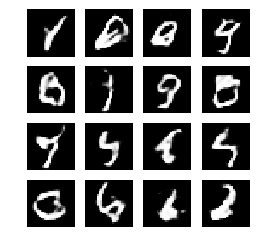

In [199]:
train(train_dataset, EPOCHS)

In [0]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [201]:
with imageio.get_writer('dcgan.gif', mode='I') as writer:
  
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    
    for i, filename in enumerate(filenames):
        frame = 2 * (i **0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
          
        image = imageio.imread(filename)
        writer.append_data(image)
        
    image = imageio.imread(filename)
    writer.append_data(image)
    
os.system('cp dcgan.gif dcgan.gif.png')

0

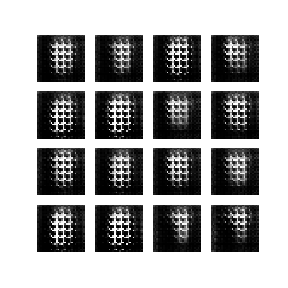

In [202]:
display.Image(filename='dcgan.gif.png')